In [25]:
from Pointcloud.Modules.Object import Pointcloud
from Pointcloud.Modules.Processor import Processor
from Pointcloud.Modules.Utils import TorchUtils

import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import torch

modelnames = []
modelnames.append("cube.obj")
# modelnames.append("HalfCube.obj")
# modelnames.append("sphere.obj")
# modelnames.append("cone.obj")
modelnames.append("Torus.obj")
# modelnames.append("Pyramid.obj")
# modelnames.append("cylinder.obj")
modelnames.append("common-3d-test-models-master/fandisk.obj")
# modelnames.append("common-3d-test-models-master/armadillo.obj")
modelnames.append("common-3d-test-models-master/stanford-bunny.obj")

In [26]:
noise_level = 0.0
pc_scale = 1

pps = []
for modelname in modelnames:
    # Sample pointcloud
    num_points = 2 ** 13
    # num_points = 1906
    pc = Pointcloud.sampleObj(modelname, num_points)
    pc.v = pc.v * pc_scale

    # Instantiate processor and shortcuts
    pp = Processor(pc)
    _graphBuilder = pp.graphBuilder

    # Add edges
    knn_edge_index = _graphBuilder.getKNNEdgeIndex(6)
    l = TorchUtils.averageEdgeLength(pp.graph.pos, knn_edge_index)

    # Calculate normals for noise generation
    pp.graph.edge_index = _graphBuilder.getKNNEdgeIndex(12)
    _graphBuilder.setAndFlipNormals(flip=False)

    # Generate noise
    pp.noise.generateNoise(noise_level, l, noise_type=0, noise_direction=1, keepNormals=True)

    # Recalculate normals of noisy points
    _graphBuilder.setAndFlipNormals(flip=True)
    pps.append(pp)

Creating MST..: 100%|██████████| 98304/98304 [00:02<00:00, 42617.81it/s]


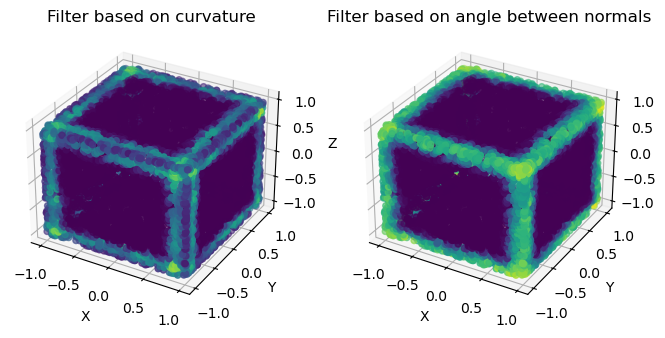

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [74]:
pp0 = pps[0]
_graph = pp0.graph
_v = _graph.pos

_n = pp0.graph.n
selection = pp0.selector.getKNNSelection(2 ** 6)
bi, j = selection.getEdgeIndex()

vj = _v[j]
dv = vj - _v[bi]
ni = _n[bi]
nj = _n[j]
wij_n = selection.scatter((ni * nj).sum(dim=1, keepdim=True).clamp_(-1, 1).abs_().acos_(), "add")
wij_new = selection.scatter(1 - (nj * torch.nn.functional.normalize(dv, dim=1)).sum(dim=1, keepdim=True).clamp_(-1, 1).abs_().acos_(), "add")

x = _v[:, 0].numpy()
y = _v[:, 1].numpy()
z = _v[:, 2].numpy()
color = wij_new.numpy()
color2 = wij_n.numpy()

f = 8
fig = plt.figure(figsize=(f, f))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter = ax1.scatter(x, y, z, c=color)
ax1.set_title("Filter based on curvature")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(x, y, z, c=color2)
ax2.set_title("Filter based on angle between normals")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

plot = mp.plot(_v.numpy(), c=color2, shading={"point_size": 0.5})
lines = plot.add_lines(_v.numpy(), (_v + 0.1 * _n).numpy())

In [71]:
final_decompositions = []
for pp in pps:
    _graph = pp.graph
    _selector = pp.selector

    # Selection
    selections = []
    selections.append(_selector.getKNNSelection(2 ** 6))
    # selections.append(_selector.getPointsInRangeSelection(
    #     TorchUtils.averageEdgeLength(
    #         _graph.pos,
    #         _selector.getKNNSelection(6).getEdgeIndex()
    #     ) * 2
    # ))

    # Decomposition
    decompositions = []
    for selection in selections:
        temp = []
        angles = [4]
        for angle in angles:
            temp.append(
                pp.decompositionor.getBetterFilteredNVT(
                    selection,
                    pp.decompositionor.getBetterFilteredNVT(
                        selection,
                        _graph.n,
                        torch.pi * angle / 12
                    ).getVUFilteredNormals(_graph.n),
                    torch.pi * angle / 12
                )
                # pp.getMyFeatureDecomposition()[0]
            )
        decompositions.append(temp)
    final_decompositions.append(decompositions)

In [75]:
# for selections in decompositions:
#     for decomposition in selections:
model_i = 2
decomposition = final_decompositions[model_i][0][0]
values = decomposition.eigval

lambda1 = values[:, 2]
lambda2 = values[:, 1]
lambda3 = values[:, 0]
linearity = (lambda2 - lambda3) / lambda1
planarity = (lambda1 - lambda2) / lambda1
sphericity = lambda3 / lambda1
linpla = linearity / (linearity + planarity)
spherpla = sphericity / (sphericity + planarity)
spherlin = sphericity / (sphericity + linearity)
scality = lambda1 / lambda1.max()

x = sphericity - planarity
y = linearity
features = torch.hstack([linearity[:, None], sphericity[:, None], planarity[:, None]])
features[features.isnan()] = 0

# color = torch.zeros_like(x)
# Cube
# color[linpla > 0.5] = 1
# color[sphericity > 0.25] = 2
# Fandisk
# color = features.clone()
# color = features / features.max(dim=1, keepdim=True).values
# color[:, 2] /= 5
# color = color.argmax(dim=1)
# color[(spherpla < 0.4).logical_or_(sphericity < 0.15)] = 0
# Perfect
# color[(sphericity > 0.2).logical_and_(linpla < 0.4)] = 1
# color[sphericity < 0.15] = 1
# color = features / features.max(dim=1, keepdim=True).values
# color = 1 - sphericity

# Eigenentropy
# color = (-values * values.log()).sum(dim=1)
# Anisotrophy
color = lambda1 - lambda3
color[color.isnan()] = 0

point_scale = l / 10
line_scale = 0.15

plot = mp.plot(features.numpy(), c=color.numpy(), shading={"point_size": 0.1})
_ = plot.add_lines(torch.eye(3), torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]]))
a = 0.3
# _ = plot.add_lines(torch.tensor([1, 0, 0]), torch.tensor([0, a, 1 - a]), shading={"line_color": "green"})
plot = mp.plot(pps[model_i].graph.pos.numpy(), c=color.numpy(), shading={"point_size": 0.5})
# _ = plot.add_lines(_pos, _pos + _graph.n * line_scale)

# smooth_n = pp.decompositionProcessor.getVUFilteredNormals(
#     pp.decompositionor.getBetterFilteredNVT(
#         selection,
#         _graph.n,
#         torch.pi * 4 / 12
#     ),
# )
# _ = plot.add_lines(_pos, _pos + smooth_n * line_scale, shading={"line_color": "orange"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4360818…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.4139499…

(4, 1, 1)


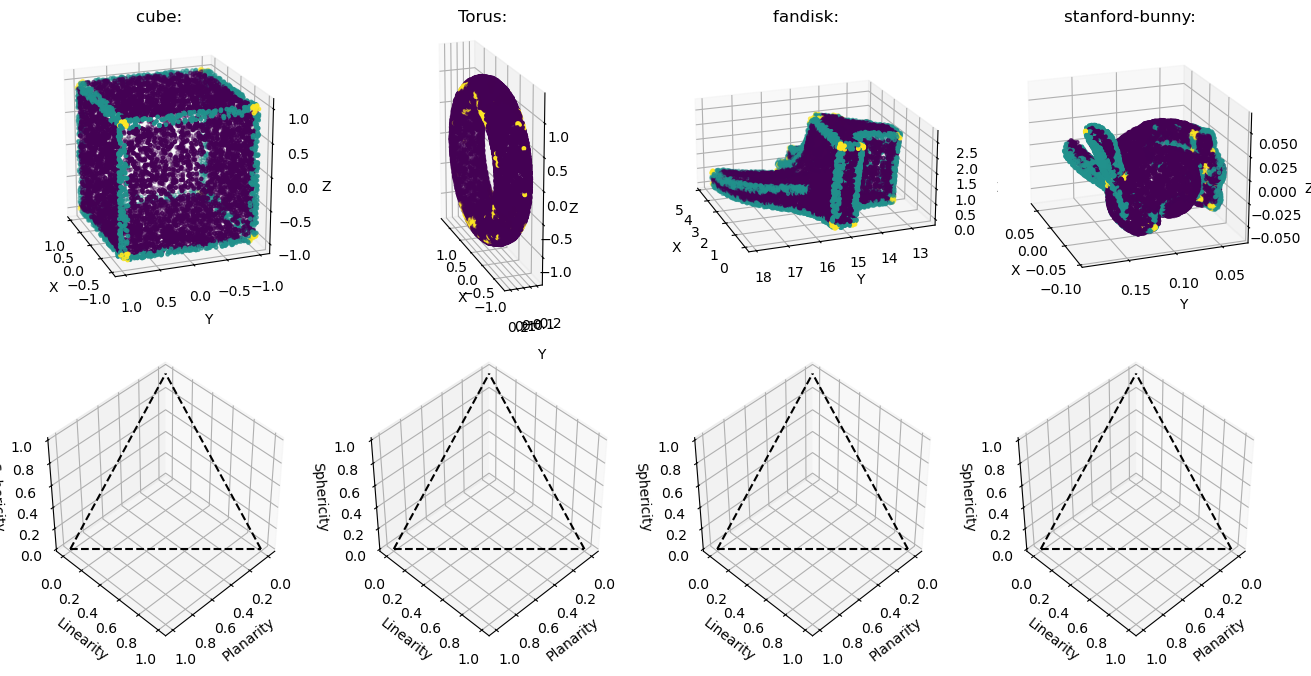

In [76]:
# Set up the 3D plot
dimensions = (len(final_decompositions), len(final_decompositions[0]), len(final_decompositions[0][0]))

ncols = dimensions[0]
nrows = dimensions[2] * 2

figsize = 4
fig = plt.figure(figsize=(figsize * ncols, figsize * nrows))
# fig.suptitle("Feature spaces")

print(dimensions)
for i, v in enumerate(final_decompositions):
    _pos = pps[i].graph.pos
    x = _pos[:, 0].numpy()
    y = _pos[:, 1].numpy()
    z = _pos[:, 2].numpy()
    for j, w in enumerate(v):
        for l, d in enumerate(w):
            features = d.eigval.clamp(0, 1)

            lambda1, lambda2, lambda3 = features[:, 2], features[:, 1], features[:, 0]
            linearity = (lambda2 - lambda3) / lambda1
            planarity = (lambda1 - lambda2) / lambda1
            sphericity = lambda3 / lambda1
            
            fx = planarity.numpy()
            fy = linearity.numpy()
            fz = sphericity.numpy()
            hi = i
            vi = l
            idx1 = 1 + (2*vi)*ncols + hi
            idx2 = 1 + (2*vi + 1)*ncols + hi
            ax1 = fig.add_subplot(nrows, ncols, int(idx1), projection='3d')
            ax2 = fig.add_subplot(nrows, ncols, int(idx2), projection='3d')
            # print(f"i: {i}\nj: {j}\nsize: ({ncols}, {nrows})\nints: ({int(idx1)}, {int(idx2)})")

            color = np.column_stack((fx, fy, fz))
            color[:, 0] /= 5
            color = color.argmax(axis=1)
            # color = color / color.max(axis=0)
            # k = 3 / 23
            # l = 3 / 5
            # color = k*l*fx - k*(1 - l)*fy - l*(1 - k)*fz > 0
            # color = 3*fx - 2*fy - 20*fz > 0
            # print(f"{modelnames[i]} -> {color.max()} -> {color.mean()}%")
            # if i == 3:
            #     print(_pos[fz / fx > 0.15].square().sum(dim=1).sqrt().mean())

            # Create a 3D scatter plot
            # cmap = 'magma'
            scatter = ax1.scatter(x, y, -z, c=color, s=6)#, cmap=cmap)
            # scatter = ax2.scatter(fx, fy, fz, c=color, s=1)#, cmap=cmap)

            # Draw boundary lines (edges of the bounding box)
            # Connecting points to form a cube or rectangular prism
            lines = [
                # The Triangle
                ([1, 0], [0, 0], [0, 1]),
                ([0, 0], [1, 0], [0, 1]),
                ([1, 0], [0, 1], [0, 0]),
            ]

            # Plot each line
            for line in lines:
                ax2.plot(line[0], line[1], line[2], color="black", linestyle="--")

            # Labels and title
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.set_zlabel('Z')
            ax2.set_xlabel('Planarity')
            ax2.set_ylabel('Linearity')
            ax2.set_zlabel('Sphericity')
            sizemin = np.column_stack((fx, fy, fz)).min(axis=0)
            sizemax = np.column_stack((fx, fy, fz)).max(axis=0)
            ax1.set_title(
                f'{pathlib.Path(modelnames[i]).stem}: '
                # f'N = {2 ** expos[j]}, ' +
                # f'rho = {angles[l]} / 12 * pi'
            )

            # Camera
            ax1.view_init(elev=20, azim=160) # Fandisk
            ax1.set_box_aspect(_pos.max(dim=0).values - _pos.min(dim=0).values) # Torus
            ax2.view_init(elev=45, azim=45)
            ax2.set_box_aspect([1, 1, 1])
            ax2.dist = 100

# Show the plot
plt.show()

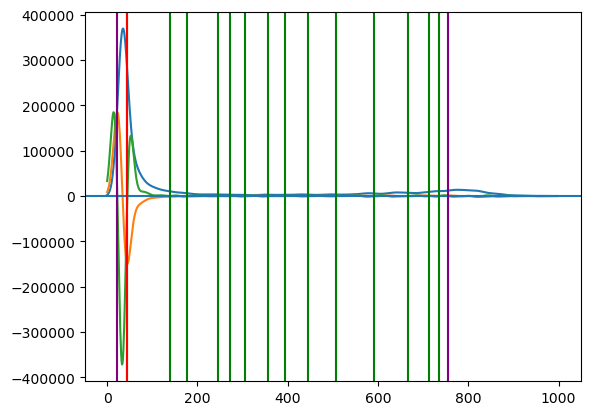

In [40]:
means = values[:, 1]
old_var = means.std() / 10
silverman_var = 0.9*torch.min(means.std(), (means.quantile(0.75) - means.quantile(0.25)) / 1.34) * num_points ** (-1/5)
scott_var = means.std() / num_points ** (1/3)
var = silverman_var
x = torch.linspace(means.min()-var*3, means.max()+var*3, 1000, dtype=torch.float64)
step_size = x[1] - x[0]
output = (-0.5 * ((x[None] - means[:, None]) / var).square()).exp() / (var * torch.sqrt(torch.tensor(2 * torch.pi)))
d = output.sum(dim=0)
v = (d[2:] - d[:-2]) / step_size
a = (d[2:] - 2*d[1:-1] + d[:-2]) / step_size ** 2
b = a[1:] - a[:-1]
c = b[1:] - b[:-1]
maxa = a.argmax()+1
tau_1 = (x[maxa+1] + x[maxa]) / 2
_ = plt.plot(d)
_ = plt.plot(v / v.max() * d.max() / 2)
_ = plt.plot(a / a.max() * d.max() / 2)
# _ = plt.plot(b / 10 ** 5)
# _ = plt.plot(c / 10 ** 4)
solution_1 = (2*a - v.abs())
argmax = solution_1.argmax()
tau_2 = (x[argmax+2] + x[argmax+1]) / 2
_ = plt.axhline(y=0)
limit = solution_1.max()
tipping_up = (a[:-1] < 0).logical_and(a[1:] > 0).nonzero().squeeze()
# for s in tipping_up:
#     plt.axvline(x=s.to(float), color="y")
tipping_down = (a[:-1] > 0).logical_and(a[1:] < 0).nonzero().squeeze()
# for s in tipping_down:
#     plt.axvline(x=s.to(float), color="b")

minmax = tipping_down[v[tipping_down].argsort()[-2:]].sort().values
tipping_up_filtered = tipping_up[(tipping_up < minmax[1]).logical_and(tipping_up > minmax[0])]
idx = tipping_up_filtered[v[tipping_up_filtered].argsort()[0]]
# idx = tipping_up_filtered[0]

for s in minmax:
    plt.axvline(x=s.to(float), color="purple")
for s in tipping_up_filtered:
    plt.axvline(x=s.to(float), color="g")

_ = plt.axvline(idx, color='r')
tau = x[idx]
# print(b[1:].size(), v[1:-1].size())
# print(v[tipping_up+1].to(int))
# plt.axvline(d.argmax(), color='r')

In [41]:
s = 4
ncols, nrows = len(pps), 4
figsize = 4
fig = plt.figure(figsize=(figsize * ncols, figsize * nrows))
for i, v in enumerate(pps):
    _pos = v.graph.pos
    vuDecomposition = v.getVUFeatures()
    fx, fy, fz = vuDecomposition.getNVTFeatures()
    myDecomposition, _ = v.getFeatureDecomposition()
    fx2, fy2, fz2 = myDecomposition.getNVTFeatures()
    colorVU = ((vuDecomposition.eigval > 0.3).sum(dim=1) % 3).numpy()
    myColor = myDecomposition.getClasses().numpy()
    ax1 = fig.add_subplot(nrows, ncols, 1 + i, projection='3d')
    _ = ax1.scatter(_pos[:, 0].numpy(), -_pos[:, 2].numpy(), _pos[:, 1].numpy(), s=s, c=colorVU)
    # ax2 = fig.add_subplot(nrows, ncols, 1 + i + ncols, projection='3d')
    # _ = ax2.scatter(fx.numpy(), fy.numpy(), fz.numpy(), c=colorVU, s=1)
    ax2 = fig.add_subplot(nrows, ncols, 1 + i + ncols, projection='3d')
    _ = ax2.scatter(_pos[:, 0].numpy(), -_pos[:, 2].numpy(), _pos[:, 1].numpy(), s=s, c=myColor)
    # ax4 = fig.add_subplot(nrows, ncols, 1 + i + 3*ncols, projection='3d')
    # _ = ax4.scatter(fx2.numpy(), fy2.numpy(), fz2.numpy(), c=myColor, s=1)

    # Draw boundary lines (edges of the bounding box)
    # Connecting points to form a cube or rectangular prism
    # lines = [
    #     # The Triangle
    #     ([1, 0], [0, 0], [0, 1]),
    #     ([0, 0], [1, 0], [0, 1]),
    #     ([1, 0], [0, 1], [0, 0]),
    # ]

    # Plot each line
    # for line in lines:
    #     ax2.plot(line[0], line[1], line[2], color="black", linestyle="--")
    #     ax4.plot(line[0], line[1], line[2], color="black", linestyle="--")

    # Labels and title
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    # ax2.set_xlabel('Planarity')
    # ax2.set_ylabel('Linearity')
    # ax2.set_zlabel('Sphericity')
    # ax4.set_xlabel('Planarity')
    # ax4.set_ylabel('Linearity')
    # ax4.set_zlabel('Sphericity')

    # Camera
    elev, azim = 20, 20
    ax1.view_init(elev=elev, azim=azim) # Fandisk
    ax2.view_init(elev=elev, azim=azim) # Fandisk
    aspect = (_pos.max(dim=0).values - _pos.min(dim=0).values).index_select(0, torch.tensor([0, 2, 1]))
    ax1.set_box_aspect(aspect) # Torus
    ax2.set_box_aspect(aspect) # Torus
    # ax2.view_init(elev=45, azim=45)
    # ax4.view_init(elev=45, azim=45)
    # ax2.set_box_aspect([1, 1, 1])
    # ax2.dist = 100

AttributeError: 'Processor' object has no attribute 'getVUFeatures'

<Figure size 1600x1600 with 0 Axes>